<div style="text-align:center"><img src="zillowprojlogo.png"/></div>

<a id='navigation'></a>

<button class="button-save large">[Scenario](#scenario)</button>
<button class="button-save large">[Project Planning](#project-planning)</button>
<button class="button-save large">[Key Findings](#key-findings)</button>
<button class="button-save large">[Tested Hypotheses](#tested-hypotheses)</button>
<button class="button-save large">[Take Aways](#take-aways)</button>
<button class="button-save large">[Data Dictionary](#data-dictionary)</button>
<button class="button-save large">[Workflow](#workflow)</button>

<div class="alert alert-block alert-info"><a name="scenario"></a><h1><i class="fas fa-home"></i> Scenario</h1></div>
Selling homes in our new normal has just gotten easier with Zillow Offers®. Now home owners can hand over the burden of selling their property, by selling directly to us based on our state of the art Zestimate score.

The accuracy and integrity of our Zestimate score is of high importance. As a junior data scientists on the Zillow data science team, we are tasked with uncovering what drivers most affect the validity of the Zestimate score. This is measured by our target variable: `logerror`, which is the difference between Zillow's estimated Zestimate and actual sale price. 
>`logerror` = log (Zestimate) − log (ActualSalePrice)

### Project Goal: 
The goal for this project is to create a model that will accurately predict the Zestimate’s `logerror`. By doing so, we will uncover what features available on the Zillow Dataset are driving the amount of error.


In [1]:
# Imports needed

import pandas as pd
import numpy as np
import os
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from env import host, user, password
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt
import wrangle

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

# Acquire
<div class="alert alert-block alert-success">
<b>Acquire Summary:</b> 
<br>- The get_connection() function from wrangle module acquires zillow dataset from Codeup database using Sequel Pro.
<br>- The zillow17() function creates a query that joins the 2017 properties and predictions data and filters data for single unit/single family homes.
<br>- The original, unprepared data set has 77574 rows and 68 columns.
</div>

In [2]:
# Acquire the data from SQL

df = wrangle.zillow17()
df

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1087254,10711855,NaN,NaN,NaN,2.0,3.0,NaN,8.0,2.0,...,6.037113e+13,-0.007357,2017-07-07,None,None,None,Central,Single Family Residential,None,None
1,1072280,10711877,1.0,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,6.037113e+13,0.021066,2017-08-29,Central,None,None,Central,Single Family Residential,None,None
2,1340933,10711888,1.0,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,6.037113e+13,0.077174,2017-04-04,Central,None,None,Central,Single Family Residential,None,None
3,1878109,10711910,NaN,NaN,NaN,2.0,3.0,NaN,8.0,2.0,...,6.037113e+13,-0.041238,2017-03-17,None,None,None,Central,Single Family Residential,None,None
4,2190858,10711923,NaN,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,6.037113e+13,-0.009496,2017-03-24,None,None,None,Central,Single Family Residential,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77569,775695,167686999,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,-0.068632,2017-02-28,None,None,None,None,Single Family Residential,None,None
77570,2863262,167687739,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,0.360020,2017-03-03,None,None,None,None,Condominium,None,None
77571,1372384,167687839,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,0.038797,2017-05-31,None,None,None,None,Single Family Residential,None,None
77572,2758757,167688532,1.0,NaN,NaN,3.0,3.0,NaN,4.0,3.0,...,NaN,0.006706,2017-02-03,Central,None,None,Central,Condominium,None,None


# Prepare
<div class="alert alert-block alert-success">
<b>Prepare Summary:</b> 
<br>-  <b>Dropped: </b> <br>
- 45 columns and 4323 rows</b> 
<br>- <b>Why drop ?! </b> 
<br>We dropped columns that had > 60% of nulls and dropped rows that had 70% of nulls because we could not gather the missing information from other variables or impute the missing values without high skew.  We also dropped columns that contained redundant information and dropped columns that contained information we would not be using in our models.
<br>- <b>Outliers: </b> <br>
- We handled outliers in taxvaluedollarcnt by dropping values > $5 million
<br>- We handled outliers in calculatedfinishedsquarefeet by dropping values < 500 sqft and > 12500 sqft
<br>- <b>Remaining missing values:</b> <br>
- lotsizesquarefeet missing values were filled with median
<br>- buildingqualitytypeid missing values were filled with median
<br>- remaining missing values were dropped
<br>- <b>Renamed columns: </b> <br>
- 9 columns renamed to accurately represent the data they contain.
<br>- Ex). calculatedfinishedsquarefeet to sqft 
<br>- <b>New features: </b> <br>
- home_age, county, logerror_quartiles
</div>

In [3]:
# Dropping unnecessary/redundant columns, dropping nulls/NaNs, and  limiting outliers 

df, train, validate, test = wrangle.wrangle_zillow()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73251 entries, 10711855 to 167655959
Data columns (total 17 columns):
bathrooms             73251 non-null float64
bedrooms              73251 non-null int64
property_quality      73251 non-null int64
sqft                  73251 non-null float64
fips                  73251 non-null int64
latitude              73251 non-null float64
longitude             73251 non-null float64
lot_sqft              73251 non-null float64
yearbuilt             73251 non-null int64
structure_value       73251 non-null float64
home_value            73251 non-null float64
land_value            73251 non-null float64
taxamount             73251 non-null float64
logerror              73251 non-null float64
county                73251 non-null object
home_age              73251 non-null int64
logerror_quartiles    73251 non-null category
dtypes: category(1), float64(10), int64(5), object(1)
memory usage: 9.6+ MB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,73251.0,2.281238e+00,0.921575,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.000000e+01
bedrooms,73251.0,3.022607e+00,0.992742,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.100000e+01
property_quality,73251.0,6.765327e+00,1.351162,1.000000e+00,6.000000e+00,7.000000e+00,7.000000e+00,1.200000e+01
sqft,73251.0,1.749733e+03,879.439591,5.010000e+02,1.174000e+03,1.522000e+03,2.069000e+03,1.203900e+04
fips,73251.0,6.049205e+03,20.952333,6.037000e+03,6.037000e+03,6.037000e+03,6.059000e+03,6.111000e+03
latitude,73251.0,3.400944e+07,269367.976599,3.333953e+07,3.381052e+07,3.402356e+07,3.417865e+07,3.481877e+07
longitude,73251.0,-1.182009e+08,364538.498469,-1.194754e+08,-1.184231e+08,-1.181701e+08,-1.179182e+08,-1.175546e+08
lot_sqft,73251.0,2.821241e+04,119114.423048,2.360000e+02,5.992000e+03,7.265000e+03,1.071250e+04,6.971010e+06
yearbuilt,73251.0,1.969858e+03,23.003074,1.878000e+03,1.954000e+03,1.971000e+03,1.987000e+03,2.016000e+03
structure_value,73251.0,1.841935e+05,181660.054449,4.400000e+01,8.473150e+04,1.365010e+05,2.180230e+05,3.348387e+06


## Explore and Split the data

In [6]:
# Check our train, validate, test

train.shape, validate.shape, test.shape

((41020, 17), (17580, 17), (14651, 17))

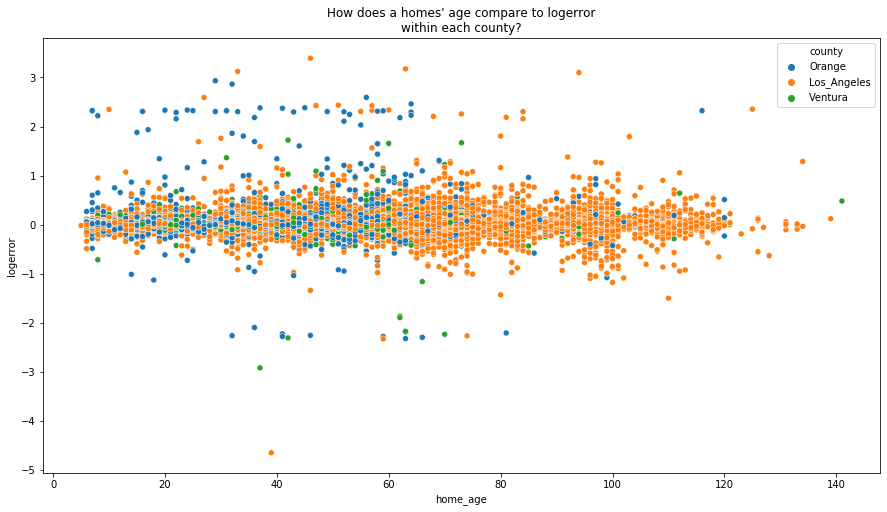

In [17]:
# How does a homes' age compare to logerror by county?

plt.rcParams['figure.figsize'] = (15.0, 8.0)
sns.scatterplot(x='home_age', y='logerror',
               data=train, hue='county')
plt.title("How does a homes' age compare to logerror\nwithin each county?")
plt.show()

In [19]:
# Create some more-nuanced features

train['structure_dollar_per_sqft'] = train.structure_value / train.sqft
train['land_dollar_per_sqft'] = train.land_value / train.lot_sqft
train['bed_bath_ratio'] = train.bedrooms / train.bathrooms

In [20]:
# Check out our data with new columns

train.head()

,bathrooms,bedrooms,property_quality,sqft,fips,latitude,longitude,lot_sqft,yearbuilt,structure_value,home_value,land_value,taxamount,logerror,county,home_age,logerror_quartiles,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio
parcelid,,,,,,,,,,,,,,,,,,,,
14187596,2.5,3,7,1596.0,6059,33867876.0,-117821531.0,3712.0,1980,129133.0,436161.0,307028.0,5396.72,0.064675,Orange,41,q4,80.910401,82.712284,1.2
12866268,2.0,4,8,1584.0,6037,34113264.0,-117702047.0,9843.0,1962,122000.0,609000.0,487000.0,7215.61,-0.035167,Los_Angeles,59,q1,77.020202,49.476786,2.0
12881212,2.0,3,4,2722.0,6037,34066151.0,-117749293.0,7074.0,1906,82000.0,241100.0,159100.0,3102.17,-0.017263,Los_Angeles,115,q2,30.124908,22.490811,1.5
10897135,1.0,1,8,816.0,6037,34166400.0,-118400000.0,22808.0,1978,116344.0,228980.0,112636.0,2807.53,-0.016783,Los_Angeles,43,q2,142.578431,4.938443,1.0
12755331,2.0,3,6,1325.0,6037,33895920.0,-118079540.0,6548.0,1948,30628.0,49239.0,18611.0,942.23,-0.002290,Los_Angeles,73,q2,23.115472,2.842242,1.5


In [21]:
# Descriptive stats on the feature

train.structure_dollar_per_sqft.describe()

count    41020.000000
mean       100.355468
std         60.274522
min          0.039833
25%         63.782026
50%         92.529592
75%        124.937205
max       1444.221106
Name: structure_dollar_per_sqft, dtype: float64

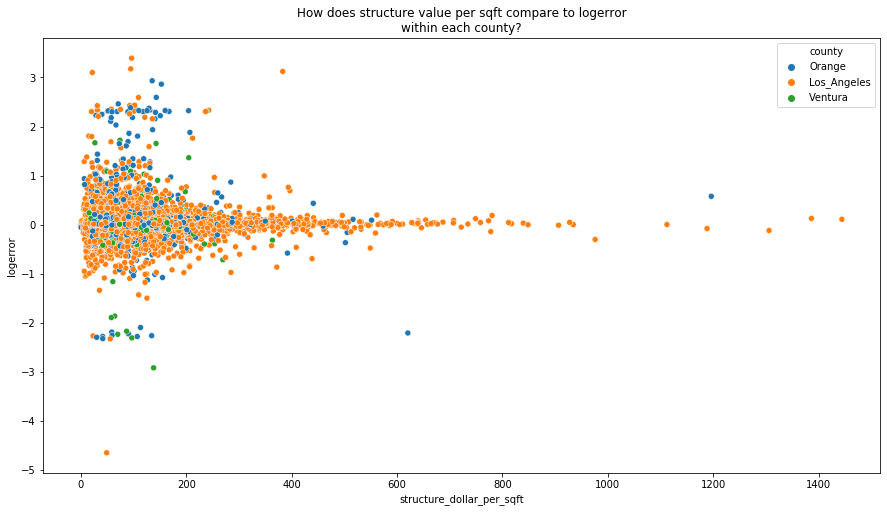

In [22]:
# Scatterplot to visualize how the homes' cost per sqft affects the logerror per county

plt.rcParams['figure.figsize'] = (15.0, 8.0)
sns.scatterplot(x='structure_dollar_per_sqft', y='logerror',
               data=train, hue='county')
plt.title("How does structure value per sqft compare to logerror\nwithin each county?")
plt.show()

In [23]:
# Descriptive stats on the feature

train.land_dollar_per_sqft.describe()

count    41020.000000
mean        41.570698
std         61.918237
min          0.003023
25%          6.502908
50%         25.668181
75%         52.552265
max       1604.525311
Name: land_dollar_per_sqft, dtype: float64

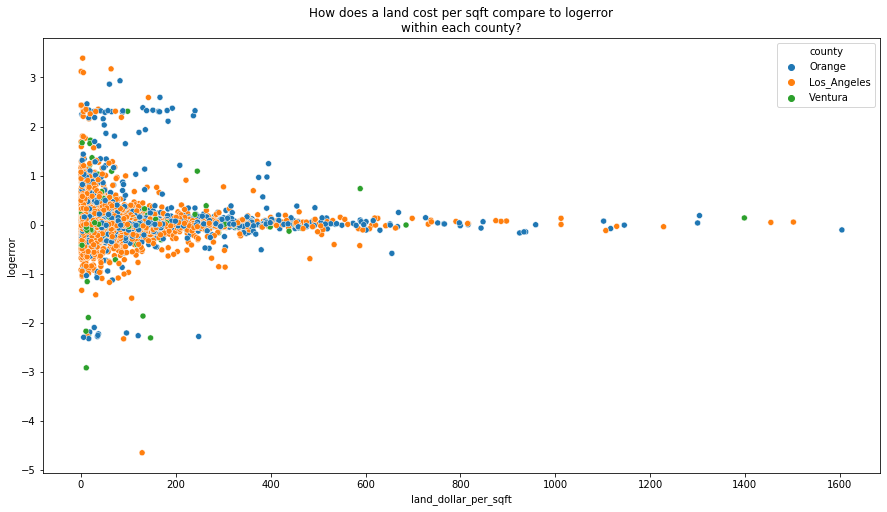

In [24]:
# Scatterplot to visualize how the lots' cost per sqft affects the logerror per county

plt.rcParams['figure.figsize'] = (15.0, 8.0)
sns.scatterplot(x='land_dollar_per_sqft', y='logerror',
               data=train, hue='county')
plt.title("How does a land cost per sqft compare to logerror\nwithin each county?")
plt.show()

In [25]:
# Descriptive stats on the feature

train.bed_bath_ratio.describe()

count    41020.000000
mean         1.447429
std          0.559801
min          0.133333
25%          1.000000
50%          1.333333
75%          1.666667
max          5.000000
Name: bed_bath_ratio, dtype: float64

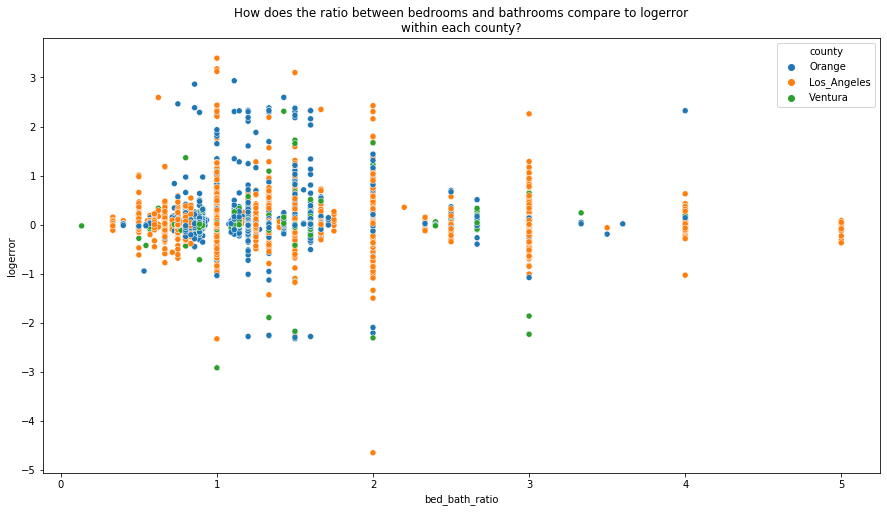

In [26]:
# Scatterplot to visualize how the bed/bath ratio affects the logerror per county

plt.rcParams['figure.figsize'] = (15.0, 8.0)
sns.scatterplot(x='bed_bath_ratio', y='logerror',
               data=train, hue='county')
plt.title("How does the ratio between bedrooms and bathrooms compare to logerror\nwithin each county?")
plt.show()

## Scale the Data

In [32]:
train.head()

,bathrooms,bedrooms,property_quality,sqft,fips,latitude,longitude,lot_sqft,yearbuilt,structure_value,home_value,land_value,taxamount,logerror,county,home_age,logerror_quartiles,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio
parcelid,,,,,,,,,,,,,,,,,,,,
14187596,2.5,3,7,1596.0,6059,33867876.0,-117821531.0,3712.0,1980,129133.0,436161.0,307028.0,5396.72,0.064675,Orange,41,q4,80.910401,82.712284,1.2
12866268,2.0,4,8,1584.0,6037,34113264.0,-117702047.0,9843.0,1962,122000.0,609000.0,487000.0,7215.61,-0.035167,Los_Angeles,59,q1,77.020202,49.476786,2.0
12881212,2.0,3,4,2722.0,6037,34066151.0,-117749293.0,7074.0,1906,82000.0,241100.0,159100.0,3102.17,-0.017263,Los_Angeles,115,q2,30.124908,22.490811,1.5
10897135,1.0,1,8,816.0,6037,34166400.0,-118400000.0,22808.0,1978,116344.0,228980.0,112636.0,2807.53,-0.016783,Los_Angeles,43,q2,142.578431,4.938443,1.0
12755331,2.0,3,6,1325.0,6037,33895920.0,-118079540.0,6548.0,1948,30628.0,49239.0,18611.0,942.23,-0.002290,Los_Angeles,73,q2,23.115472,2.842242,1.5


In [30]:
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.features_target_split(df, 'logerror')

NameError: name 'train' is not defined

In [31]:
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.Standard_Scaler(X_train, X_validate, X_test)

NameError: name 'X_train' is not defined